In [2]:
import sys 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid.inset_locator import inset_axes
sys.path.append('D:\PycQED')
from collections import OrderedDict as od
# from pycqed.analysis import measurement_analysis as MA 
# from pycqed.analysis import analysis_toolbox as a_tools
# import pycqed.analysis_v2.spectroscopy_analysis as ma2
# from pycqed.analysis import fitting_models as fit_mods
from scipy import constants
from scipy import optimize
import scipy
import math
import ipywidgets
import pandas as pd

import lmfit
import colorsys as colors
from IPython.display import display
# from nw_plotting_tools import *
# execfile('nw_figure_settings.py')
# savedir = 'D:\\Experiments\\1801_Holy_Chip\\Data_Figures\\'
# reload(MA)
# reload(a_tools)
%matplotlib inline
# print(savedir)

# Load the data

In [6]:
params_dict_feed = {'f_res':'sweep_points',
                      'amp':'amp',
                      'phase':'phase',
#                       'power': 'VNA.power',
                   'temp':'Fridge monitor.T_MClo'
                   }
numeric_params_feed = ['f_res','amp','phase', 'power']

# total = len(feed_dict['feed_timestamps']) -1 # Used for color 

# feed_dict['data'] = []

#During condens
# '20190508_102955'
#after condes high power
# '20190509_031350',
#after condens low power
# 20190509\033413
feed_dict = a_tools.get_data_from_timestamp_list( '20190917_180439',#'20190509_033413',
                                                 params_dict_feed,
                                                 numeric_params=numeric_params_feed,
                                                 filter_no_analysis=False)
#         feed_dict['data'][tt]['color'] = (1.-tt/total,tt/total,tt/(total)) # (red,green,blue), changed the color code to be consistend with the others, red = 250 mT and light blue = 0 mT
        
## Convert to dB
feed_dict['amp_dB'] = 10.*np.log10(feed_dict['amp'])


# Plot the feedline data vs field

0.5744


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans



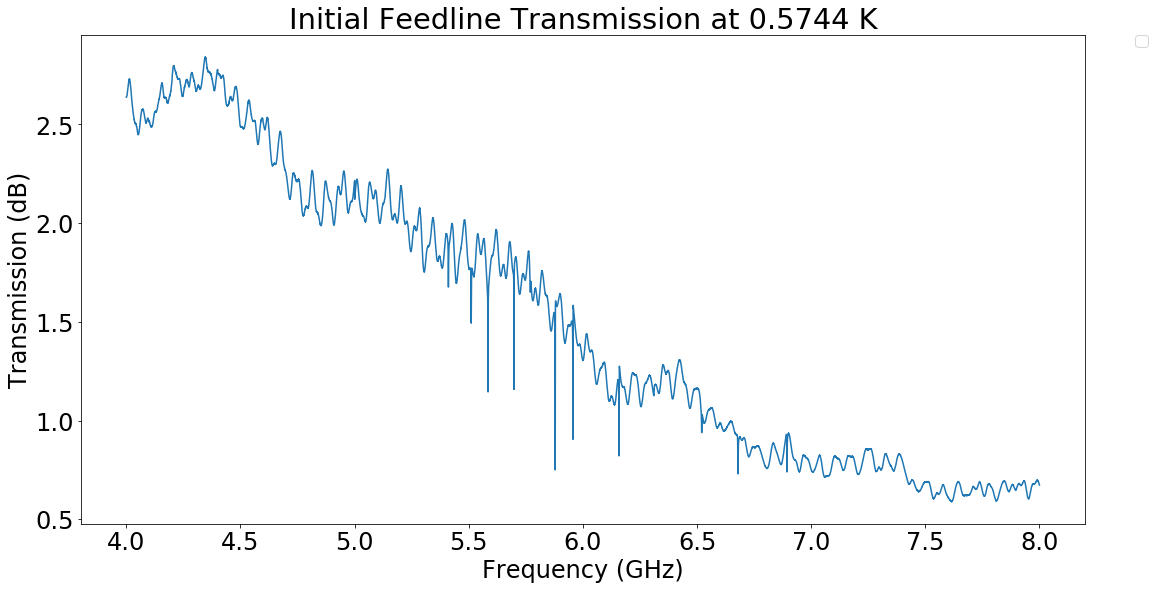

In [7]:
# Log scale
%matplotlib inline
font_size = 24
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : font_size}
matplotlib.rc('font', **font)
matplotlib.rcParams.update({'font.size': font_size})

figr = plt.figure(figsize=(18,9))
ax = figr.add_subplot(111)

# ax.axvline(5.06,c='r')
ax.plot(feed_dict['f_res']*1e-9,feed_dict['amp'])    

ax.set_ylabel('Transmission (dB)')
ax.set_xlabel('Frequency (GHz)')
print(feed_dict['temp'])
ax.set_title('Initial Feedline Transmission at '+str(feed_dict['temp'])+' K')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
# ax.set_xlim(5,7.4)
# ax.set_ylim(0,2.1)

# Automatically find Resonator frequencies

[5.2944 5.4108 5.4368 5.5112 5.5848 5.6984 5.768  5.8792 5.9564 6.1588
 6.3124 6.6792 6.894 ]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans



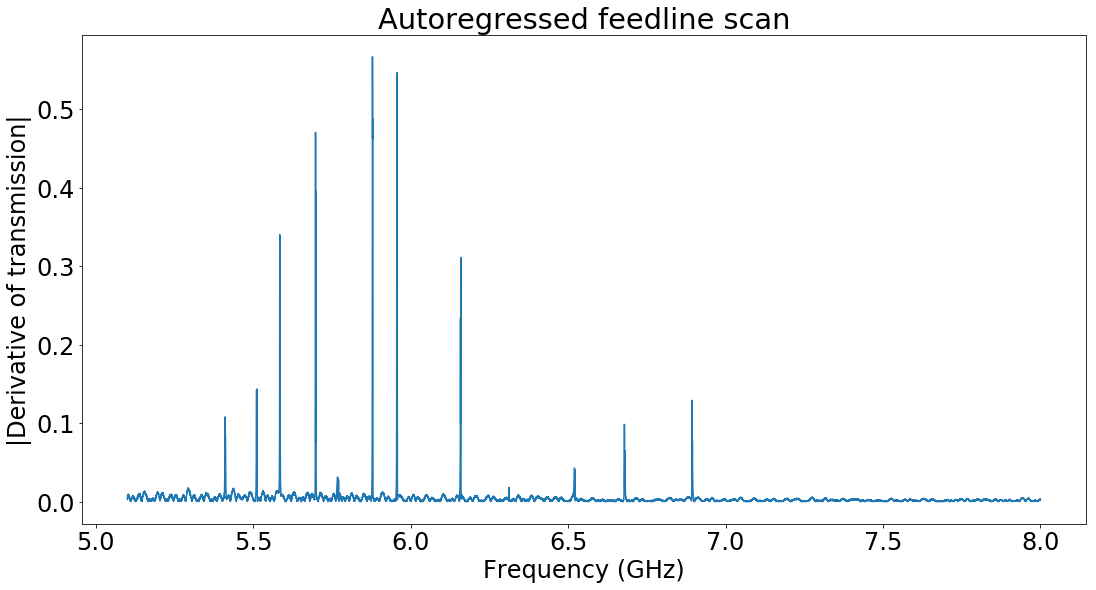

In [17]:

# Log scale
%matplotlib inline
font_size = 24
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : font_size}
matplotlib.rc('font', **font)
matplotlib.rcParams.update({'font.size': font_size})

figr = plt.figure(figsize=(18,9))
ax = figr.add_subplot(111)

#Try to find the frequencies automatically
ar_def = feed_dict['amp'][2:]-0.5*(feed_dict['amp'][1:-1]+feed_dict['amp'][:-2])
f_res_def = feed_dict['f_res'][2:]
ar_def = ar_def[f_res_def>5.1e9]
f_res_def = f_res_def[f_res_def>5.1e9]
ax.plot(f_res_def*1e-9,np.abs(ar_def))
ax.set_title('Autoregressed feedline scan')

ax.set_ylabel('|Derivative of transmission|')
ax.set_xlabel('Frequency (GHz)')
# plt.yscale('log')
# ax.set_xlim(6.4,6.6)
print(np.sort((a_tools.peak_finder_v2(f_res_def*1e-9,np.abs(ar_def)))[0:13]))

In [3]:
from scipy.optimize import minimize
from scipy.linalg import null_space
class resonator:
    
    # general mathematical functions
    ## values are know constants set by the user
    ## params are used for optimization to calculate the right value
    short_dict = {'params':None,
                       'S_matrix':-np.matrix([[0,1],[1,0]],dtype='float'),
                      }
    open_dict = {'params':None,
                      'S_matrix':np.matrix([[0,1],[1,0]],dtype='float'),
                      }
    
    def segment(self,length):
        segment_dict = {'params':'k',
                         'S_matrix':lambda k: self.propagator(k,z=length),
                         'values':{'length':length}
                        }
        return segment_dict
    
    def propagator(self,k,z):
        return np.matrix([[np.exp(1j*k*z),0],[0,np.exp(-1j*k*z)]])
    
    def __init__(self,Z0=None,phi0=None,lc=None,cc=None):
        self.Z0 = Z0
        self.phi0 = phi0
        self.lc = lc
        self.cc = cc
        self.length = None
        self.elements = list()
    
    def add_short(self):
        self.elements.append(self.short_dict) 
        return self
    
    def add_inductive_short(self):
        pass
    
    def add_open(self):
        self.elements.append(self.open_dict)
        return self
        
    def add_segment(self, length):
        self.elements.append(self.segment(length))
        self.length = length
        return self
        
    def get_eigenmode(self):
        self.params = self.get_params()
        self.transmission_function = self.get_transmission_function()
        guess = self.get_mode_guess(*self.params)
        def mode_condition(k,params):
            T = self.transmission_function(k,params)
            mode_condition = np.linalg.det(np.subtract(np.eye(2),T))
            return mode_condition
            
        result = minimize(mode_condition,guess,args=(self.params))

        self.k_res = abs(result['x'][0])
        self.omega_res = self.k_res*self.phi0
        self.f_res = self.omega_res/2/np.pi
#         self.tolerance = result
        return self.k_res, self.f_res
    
    def get_eigenfunction(self):
        
        #calculate nullspace
        def eigenfunction(z):
            params = self.get_params()
            k_res = self.k_res
            T = self.transmission_function([k_res],params)
            eigenfunction_coefficients = null_space(np.subtract(np.eye(2),T),rcond=1)
            return list(map(lambda zv: np.sum(np.matmul(eigenfunction_coefficients,self.propagator(k_res,zv))),z))

        return eigenfunction
    
    #helper functions
    def get_mode_guess(self,params):
        if params == 'k':
            return 3*np.pi/4/self.length
        else:
            raise NotImplementedError('Parameter %s is not implemented yet'%(self.params))
        
    def get_params(self):
        params = list()
        for e in self.elements:
            if e['params']:
                params.extend([p for p in e['params']])
        params = list(set(params))
        return params
    
    def get_transmission_function(self):
        params = self.get_params()
        
        def transmission(k,params):
            # extracting the parameters
            param_dict = {}
            for tt,p in enumerate(params):
                param_dict[p] = k[tt]

            # constructing the mode condition with the appropriate parameters
            T = np.eye(2)
            for e in self.elements:
                if e['params'] is None:
                    S = e['S_matrix']
                else:
                    params = {p:param_dict[p] for p in e['params']}
                    S = e['S_matrix'](**params)
                    
                T = np.matmul(T,S)
            # calculating the mode condition
            return T

        return transmission

    

#     def get_
        

In [4]:
q1_params = {'Z0':50,
             'phi0':0.96e8,
             'lc':None,
             'cc':None}
L = 4414.2e-6
q1 = (resonator(**q1_params)
      .add_segment(length = L)
      .add_short()
      .add_segment(length = -L)
      .add_open()
)

kopt = q1.get_eigenmode()
print(kopt)

(355.850740494694, 5436998817.853617)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)


[(-2+0j), (-1.999748255343937+0j), (-1.9989930847511193+0j), (-1.9977346783317085+0j), (-1.9959733528827959+0j), (-1.9937095518086505+0j), (-1.990943845009095+0j), (-1.9876769287360372+0j), (-1.9839096254181898+0j), (-1.9796428834540312+0j), (-1.9748777769730497+0j), (-1.9696155055653373+0j), (-1.9638573939795998+0j), (-1.957604891789658+0j), (-1.950859573029525+0j), (-1.9436231357971523+0j), (-1.935897401826942+0j), (-1.9276843160311352+0j), (-1.9189859460101908+0j), (-1.9098044815322783+0j), (-1.9001422339820144+0j), (-1.8900016357785858+0j), (-1.8793852397633994+0j), (-1.8682957185574187+0j), (-1.8567358638883456+0j), (-1.8447085858878176+0j), (-1.8322169123587986+0j), (-1.819263988013345+0j), (-1.8058530736809408+0j), (-1.7919875454876022+0j), (-1.7776708940059556+0j), (-1.762906723376504+0j), (-1.7476987504003043+0j), (-1.7320508036032833+0j), (-1.7159668222724256+0j), (-1.6994508554640788+0j), (-1.6825070609846273+0j), (-1.665139704343784+0j), (-1.647353157680774+0j), (-1.6291518

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


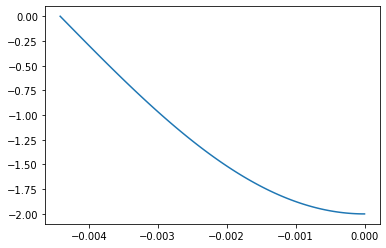

In [5]:
plotfn = q1.get_eigenfunction()
z_vals = np.linspace(0,-L,100)
# [print(x) for x in list(map(lambda x: q1.propagator(711,x),z_vals))]
print(plotfn(z_vals))
plt.plot(z_vals,plotfn(z_vals))
# plotfn(z_vals)

In [6]:
T  = np.array([[-0.7259323+0.68776616j,0.+0.j],
                [0.+0.j,-0.7259323-0.68776616j]])
np.linalg.det(T)
1423.19931396*0.96e8

136627134140.15999

In [7]:
null_space(np.eye(2)-np.eye(2))

array([[1., 0.],
       [0., 1.]])

In [8]:
A = [[1.-2.38055826e-08j, 0],
 [0, 1.+2.38055826e-08j]]
B = np.eye(2)-A

In [9]:
null_space(B,rcond=1)

array([[-1.-0.j, -0.-0.j],
       [-0.-0.j, -1.-0.j]])

In [10]:
np.matrix([[np.exp(1j*711*L),0],[0,np.exp(-1j*711*L)]])

matrix([[-0.99999521+0.00309645j,  0.        +0.j        ],
        [ 0.        +0.j        , -0.99999521-0.00309645j]])